# 4 AMC + Demodulation Using LSTM Seq2Seq Autoencoder

In this notebook we re-use the same Seq2Seq architecture as for QPSK, but add BPSK into the mix. This means that the model now has to classify 6 classes, instead of 4, learning to do AMC implicitly.

## Import libraries

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from comms import awgn, make_rrc, modulate, demodulate, pulse_shape

## Define baseline

Upper bound baseline, matched filter + demodulator. Can't do better than this, and most likely won't.

In [2]:
def calc_baseline(snr, num_iter=512, M=2, sps = 4, span = 10):
    
    num_weights = sps*span+1
    hrrc = make_rrc(num_weights=num_weights, fs=sps)
    
    ints = np.random.randint(low=0, high=M, size=(num_iter))
    samples = modulate(ints, M=M)
    
    samples = pulse_shape(samples, hrrc, sps=sps)
    samples = awgn(samples, snr, measured=True)

    syms_filtered = np.convolve(samples, hrrc, mode='same')
    extract_symbols = syms_filtered[np.arange(0,len(samples),sps)]
    extract_symbols /= np.sqrt(np.mean(np.abs(extract_symbols)**2)) # normalize to unit power
    
    num_correct = sum(demodulate(extract_symbols, M=M) == ints)
    
    return num_correct/num_iter

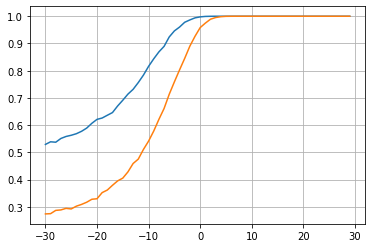

In [3]:
snr_range = np.arange(-30,30)

bpsk_baseline, qpsk_baseline, psk_baseline = [], [], []
for snr in snr_range:
    bpsk_baseline.append(calc_baseline(snr=snr, M=2, num_iter=1024*16))
    qpsk_baseline.append(calc_baseline(snr=snr, M=4, num_iter=1024*16))
#     psk_baseline.append(calc_baseline(snr=snr, M=8, num_iter=2048))

bpsk_baseline = np.array(bpsk_baseline)
qpsk_baseline = np.array(qpsk_baseline)
# psk_baseline = np.array(psk_baseline)
    
plt.plot(snr_range, bpsk_baseline)
plt.plot(snr_range, qpsk_baseline)
# plt.plot(snr_range, psk_baseline)
# plt.plot(snr_range, (bpsk_baseline+qpsk_baseline+psk_baseline)/3, '--')
plt.grid()

## Generate training data

We will need pairs of sequences of pulse shaped symbols and labels. 

E.g. when training for 5 pulse shaped symbols at sps=8, we will have a x_train inputs be of shape batch x 40 x 2, where the last dimension represents real and imaginary channels, and the corresponding y_train will be a sequence of batch x 5, for the 5 classes reprented in 5 pulse shaped symbols taking up 40 samples.

In [4]:
def gen_data(num_examples, seq_length, mod_order=4, sps=4, span=10, snr=50, normalize=True):
    '''
    This function produces a num_examples number of pulse shaped M-QAM waveforms, each
    example is made up from seq_length*sps samples.
    '''
    
    # Calculate number of weights based on sps and span, and create an RRC filter
    num_weights= sps*span+1
    hrrc = make_rrc(num_weights=num_weights, fs=sps)
    
    # Generate random bits
    ints = np.random.randint(low=0, high=mod_order, size=(num_examples * seq_length))
    
    # Modulate according to mod order
    samples = modulate(ints, M=mod_order)
    
    # Pulse shape / upsample the symbols
    samples_pulse_shaped = pulse_shape(samples, hrrc, sps=sps)
    
    # Add noise. IMPORTANT -> measured=True (keep note of this when eveluating)
    samples_noisy = awgn(samples_pulse_shaped, snr, measured=True)
    
    # Reshape the vectors into a new array of shape [num_examples, seq_length]
    data = samples_noisy.reshape(num_examples,-1)
    labels = ints.reshape(num_examples,-1)
    
    # Optionally normalize the waveform (helps with training)
    if normalize:
        data = (data/np.max(np.abs(data),axis=1)[:,None])
    
    return data, labels

def to_tensors(x,y, onehot=False, gpu=False, batch_first=False, normalize=True, num_classes=None):
    '''
    This function takes the outputs from gen_data and does the necessary formatting
    to make the data compatible with torch nn layers.
    '''
    
    # Split complex x into real/imaginary along 3rd axis
    # 2d -> 3d tensor
    x = torch.FloatTensor(np.stack((x.real, x.imag), axis=2))
    
    # One hot encoding if doing MSE/CrossEntropy
    # Otherwise NLLLoss will take the LongTensor
    if onehot:
        y = torch.LongTensor(y)
        if num_classes:
            y = F.one_hot(y, num_classes=num_classes)
        else:
            y = F.one_hot(y, num_classes=len(np.unique(y)))
    else:
        y = torch.LongTensor(y)
        
    # LSTM expects (seq, batch, feats) input shape
    if not batch_first:
        x = x.permute((1,0,2))
        if onehot:
            y = y.permute((1,0,2))
        else:
            y = y.unsqueeze(2).permute((1,0,2))
    
    # Move to cuda device memory if gpu is used
    if gpu:
        x = x.cuda()
        y = y.cuda()
    
    return x,y

## Architecture

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu'):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers)

    def forward(self, input, hidden):
        
        output, hidden = self.rnn(input, hidden)
        
        return output, hidden
    
    def initHidden(self, batch_size=32, device='cpu'):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device), 
                torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
    
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu'):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers=num_layers)
        self.out = nn.Linear(hidden_size, input_size)

    def forward(self, input, hidden):
        rnn_output, hidden = self.rnn(input, hidden)
        
#         y = self.out(hidden[0])
        y = self.out(rnn_output)
        
        return y, hidden

## Training

Define the training and validation functions for one epoch.

In [9]:
def gen_dataset(data_config, train_config):
    
    # if multiple SNR
    if type(data_config['snr']) == np.ndarray:
        datas, labels = [], []
        for sn in data_config['snr']:
            if data_config['num_examples_bpsk'] > 0:
                x_bpsk, y_bpsk = gen_data(data_config['num_examples_bpsk'],
                                data_config['seq_length'],
                                sps=data_config['sps'],
                                mod_order=2,
                                snr=sn)
                datas.append(x_bpsk)
                labels.append(y_bpsk)
            
            if data_config['num_examples_qpsk'] > 0:
                x_qpsk, y_qpsk = gen_data(data_config['num_examples_qpsk'],
                                data_config['seq_length'],
                                sps=data_config['sps'],
                                mod_order=4,
                                snr=sn)
                
                y_qpsk += 2
                
                datas.append(x_qpsk)
                labels.append(y_qpsk)

        x = np.concatenate((datas))
        y = np.concatenate((labels))
    
    # if single SNR
    else:
        x_bpsk, y_bpsk = gen_data(data_config['num_examples_bpsk'], 
                                  data_config['seq_length'], 
                                  mod_order=2, sps=data_config['sps'], 
                                  snr=data_config['snr'])

        x_qpsk, y_qpsk = gen_data(data_config['num_examples_qpsk'], 
                                  data_config['seq_length'], 
                                  mod_order=4, sps=data_config['sps'], 
                                  snr=data_config['snr'])
        y_qpsk += 2
        x = np.concatenate((x_bpsk, x_qpsk))
        y = np.concatenate((y_bpsk, y_qpsk))

    x, y = to_tensors(x, y, batch_first=True, gpu=True, onehot=True, num_classes=6)

    train_dataset = torch.utils.data.TensorDataset(x, y)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
    
    return train_dataloader

def train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, teacher_forcing=False, gpu=True, num_classes=6):
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # format to (seq x batch x feats) format
    x_train = x_train.permute((1,0,2))
    y_train = y_train.permute((1,0,2))

    loss = 0

    encoder_hidden = encoder.initHidden(batch_size=x_train.shape[1], device = 'cuda' if gpu else 'cpu')
    _, encoder_hidden = encoder(x_train, encoder_hidden)

    decoder_hidden = encoder_hidden

    decoder_input = torch.zeros((1,x_train.shape[1],num_classes))
    if gpu:
        decoder_input = decoder_input.cuda()

    for i in range(y_train.shape[0]):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
        loss += criterion(y.squeeze(), y_train[i].argmax(axis=1)) # cross entropy

        if teacher_forcing:
            decoder_input = y_train[i].float().unsqueeze(0)
        else:
            decoder_input = y

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()/y_train.shape[0]

def val_step(x_val, y_val, encoder, decoder, criterion, gpu=True, num_classes=6):

    x_val = x_val.permute((1,0,2))
    y_val = y_val.permute((1,0,2))

    loss = 0

    encoder_hidden = encoder.initHidden(batch_size=x_val.shape[1], device = 'cuda' if gpu else 'cpu')
    _, encoder_hidden = encoder(x_val, encoder_hidden)

    decoder_hidden = encoder_hidden

    decoder_input = torch.zeros((1,x_val.shape[1],num_classes))
    if gpu:
        decoder_input = decoder_input.cuda()

    for i in range(y_val.shape[0]):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
#         loss += criterion(y.squeeze(), y_val[i].squeeze().float()) #mse
        loss += criterion(y.squeeze(), y_val[i].argmax(axis=1)) # cross-entropy
        decoder_input = y
    
    return loss.item()/y_val.shape[0]

def inference(x_test, encoder, decoder, num_classes=6, seq_length=5, batch_size=32):
    
    encoder_hidden = encoder.initHidden()

    encoder_hidden = encoder.initHidden(batch_size=batch_size)
    _, encoder_hidden = encoder(x_test, encoder_hidden)

    decoder_hidden = encoder_hidden

    decoder_outputs = torch.zeros((seq_length,batch_size,num_classes))
    decoder_input = torch.zeros((1,batch_size,num_classes))
    
    for i in range(seq_length):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
        decoder_outputs[i] = y
        decoder_input = y
        
    return decoder_outputs

def eval_accuracy(encoder, decoder, snr_range, mod_order=2, num_examples=256, seq_length=5, sps=4, num_classes=6, batch_size=32):
    
    accuracies = []
    
    for snr in snr_range:

        x, y = gen_data(num_examples, seq_length, mod_order=mod_order, sps=sps, snr=snr)
        if mod_order == 4:
            y += 2
        if mod_order == 8:
            y += 6
        x,y = to_tensors(x,y,batch_first=True)

        # create dataset and dataloader
        test_dataset = torch.utils.data.TensorDataset(x, y)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

        corrects, totals = 0, 0
        for x,y in test_dataloader:
            x = x.permute((1,0,2))
            y = y.unsqueeze(2).permute((1,0,2))
            y_hat = inference(x, encoder, decoder, num_classes=num_classes, seq_length=seq_length)

            corrects += torch.sum(y_hat.argmax(axis=2) == y.squeeze())

            totals += y.numel()

        accuracy = np.array(corrects)/totals

        accuracies.append(accuracy)
    
    return accuracies

## Train and evaluate

Define a simple evaluation function. Don't forget to load the models back into main memory from cuda.

In [10]:
model_config = {'hidden_size': 16,
                'num_layers': 3,
                'input_size': 2,
                'output_size': 6}

data_config = {'snr': np.arange(-5,21,5),
               'num_examples_bpsk': 4096,
               'num_examples_qpsk': 4096,
               'seq_length': 5,
               'sps': 4,
               'span': 10,
               'num_examples_val': 256}

train_config = {'num_epochs': 200,
                'batch_size': 64,
                'learning_rate': 0.001,
                'weight_decay': 0.0001,
                'device': 'cuda',
                'teacher_forcing': False}

test_config = {'snr_range': np.arange(-30,30),
               'num_iter': 1024}

In [11]:
np.random.seed(0)
train_dataloader = gen_dataset(data_config, train_config)

# val_dataloader_bpsk = gen_dataset(data_config_bpsk_val, train_config)
# val_dataloader_qpsk = gen_dataset(data_config_qpsk_val, train_config)

0: Best loss 1.1721482038497926, saving...
1: Best loss 0.8220482230186462, saving...
2: Best loss 0.6769174993038177, saving...
3: Best loss 0.5783633579810461, saving...
4: Best loss 0.524771100282669, saving...
5: Best loss 0.47660531749327983, saving...
6: Best loss 0.4520447850227356, saving...
7: Best loss 0.4002118994792302, saving...
9: Best loss 0.34993901699781416, saving...
10: Best loss 0.32635655055443447, saving...
11: Best loss 0.3118946368495623, saving...
12: Best loss 0.3039939671754837, saving...
14: Best loss 0.29027401308218637, saving...
15: Best loss 0.28157962461312613, saving...
16: Best loss 0.2711591159303983, saving...
17: Best loss 0.2632420979440212, saving...
18: Best loss 0.2590340388317903, saving...
19: Best loss 0.2478372101982435, saving...
20: Best loss 0.2418222467104594, saving...
22: Best loss 0.2357805281877518, saving...
23: Best loss 0.23243185281753537, saving...
25: Best loss 0.22676084339618685, saving...
28: Best loss 0.22565395732720694, 

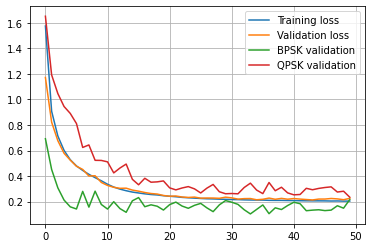

In [13]:
# Loss function - MSE works best for some reason
# criterion = nn.MSELoss()
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

# Create the encoder and decoder models
encoder = EncoderRNN(hidden_size=16, input_size=2, num_layers=3, device = 'cuda' if gpu else 'cpu')
decoder = DecoderRNN(hidden_size=16, input_size=6, num_layers=3, device = 'cuda' if gpu else 'cpu')

encoder.cuda()
decoder.cuda()

# Initialize the optimizers
encoder_optimizer = optim.Adam(encoder.parameters(), lr=3e-4, weight_decay=0.0001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=3e-4, weight_decay=0.0001)

# Define empty lists where loss progress will be stored
losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

best_loss = np.inf

# Training loop
for epoch in range(50):
    train_loss = 0
    for x_train,y_train in train_dataloader:
        
        train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, 
                                 teacher_forcing=False, gpu=gpu)

    losses.append(train_loss/len(train_dataloader))
    
    with torch.no_grad():
        val_loss = 0
        for x_val,y_val in val_dataloader_bpsk:
            val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
        val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))
        
        val_loss = 0
        for x_val,y_val in val_dataloader_qpsk:
            val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
        val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))
        
        val_loss = (val_losses_bpsk[-1] + val_losses_qpsk[-1])/2
        val_losses.append(val_loss)
        
        if val_loss < best_loss:
            encoder_weights = encoder.state_dict()
            decoder_weights = decoder.state_dict()
            best_loss = val_losses[-1]
            print(f"{epoch}: Best loss {best_loss}, saving...")
        
encoder.load_state_dict(encoder_weights)
decoder.load_state_dict(decoder_weights)
        
plt.plot(losses)
plt.plot(val_losses)
plt.plot(val_losses_bpsk)
plt.plot(val_losses_qpsk)
plt.grid()
plt.legend(('Training loss', 'Validation loss', 'BPSK validation', 'QPSK validation'))

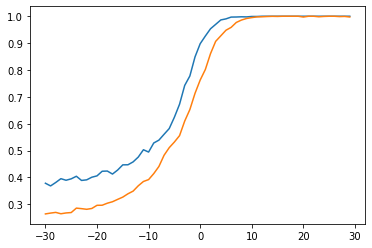

In [14]:
saved = np.load('results/dt_baselines.npz')
plt.plot(saved['snr_range'], saved['bpsk_baseline'])
plt.plot(saved['snr_range'], saved['qpsk_baseline'])

In [15]:
encoder.cpu()
decoder.cpu()

bpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=1024, mod_order=2)
qpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=1024, mod_order=4)

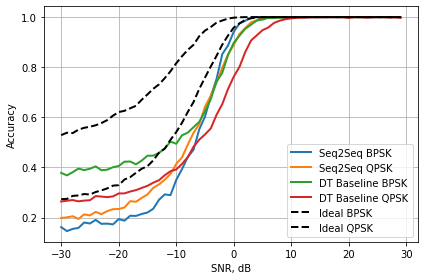

In [16]:
plt.plot(snr_range, bpsk_accs, linewidth=2, markevery=5)
plt.plot(snr_range, qpsk_accs, linewidth=2, markevery=5)
plt.plot(snr_range, saved['bpsk_baseline'], linewidth=2, markevery=5)
plt.plot(snr_range, saved['qpsk_baseline'], linewidth=2, markevery=5)
plt.plot(snr_range, bpsk_baseline, 'k--', linewidth=2)
plt.plot(snr_range, qpsk_baseline, 'k--', linewidth=2)
plt.grid()
plt.xlabel('SNR, dB'); plt.ylabel('Accuracy')
plt.legend(('Seq2Seq BPSK', 'Seq2Seq QPSK', 'DT Baseline BPSK', 'DT Baseline QPSK', 'Ideal BPSK', 'Ideal QPSK'))
plt.tight_layout()

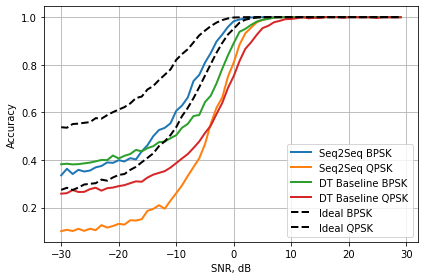

In [16]:
plt.plot(snr_range, bpsk_accs, linewidth=2, markevery=5)
plt.plot(snr_range, qpsk_accs, linewidth=2, markevery=5)
plt.plot(snr_range, saved['bpsk_baseline'], linewidth=2, markevery=5)
plt.plot(snr_range, saved['qpsk_baseline'], linewidth=2, markevery=5)
plt.plot(snr_range, bpsk_baseline, 'k--', linewidth=2)
plt.plot(snr_range, qpsk_baseline, 'k--', linewidth=2)
plt.grid()
plt.xlabel('SNR, dB'); plt.ylabel('Accuracy')
plt.legend(('Seq2Seq BPSK', 'Seq2Seq QPSK', 'DT Baseline BPSK', 'DT Baseline QPSK', 'Ideal BPSK', 'Ideal QPSK'))
plt.tight_layout()

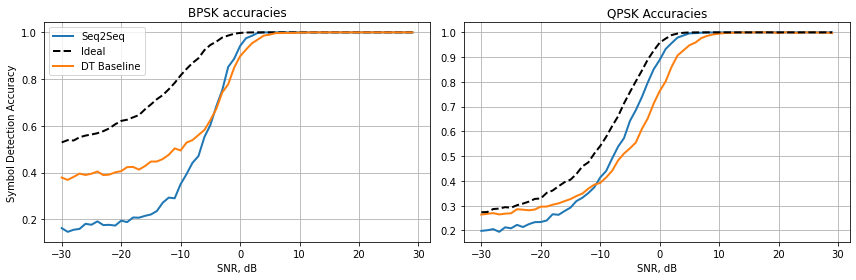

In [17]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(snr_range, np.array(bpsk_accs), '-', linewidth=2)
ax[0].plot(snr_range, np.array(bpsk_baseline), 'k--', linewidth=2)
ax[0].plot(snr_range, saved['bpsk_baseline'], '-', linewidth=2)
ax[0].grid()
ax[0].legend(('Seq2Seq', 'Ideal', 'DT Baseline'))
ax[0].set_xlabel('SNR, dB'); ax[0].set_ylabel('Symbol Detection Accuracy')
ax[0].set_title('BPSK accuracies')


ax[1].plot(snr_range, np.array(qpsk_accs), '-', linewidth=2)
ax[1].plot(snr_range, saved['qpsk_baseline'], '-', linewidth=2)
ax[1].plot(snr_range, np.array(qpsk_baseline), 'k--', linewidth=2)
ax[1].grid()
# ax[1].legend(('Seq2Seq', 'Ideal', 'DT Baseline'))
ax[1].set_xlabel('SNR, dB'); ax[0].set_ylabel('Symbol Detection Accuracy')
ax[1].set_title('QPSK Accuracies')

plt.tight_layout()
# plt.savefig('figures/seq2seq_symbol_detection_accs.png', dpi=300)

## Train data size vs mean accuracy

In [29]:
train_config = {'num_epochs': 100,
                'batch_size': 64,
                'learning_rate': 3e-4,
                'weight_decay': 0.0001,
                'device': 'cuda',
                'teacher_forcing': False}

# 'snr': np.array([-10, -5, 0, 5, 10, 15])
data_config = {'snr': np.arange(-5,21,5),
               'num_examples_bpsk': 4096,
               'num_examples_qpsk': 4096,
               'seq_length': 5,
               'sps': 4,
               'span': 10,
               'num_examples_val': 256}

In [30]:
train_sizes = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
# model_configs = [(16,3), (128,3)]
model_configs = [(16,2), (128,2)]

for model_config in model_configs:
    for train_size in train_sizes:
        print(train_size)
        data_config['num_examples_bpsk'] = train_size
        data_config['num_examples_qpsk'] = train_size
        
        np.random.seed(0)
        train_dataloader = gen_dataset(data_config, train_config)
        
        criterion = nn.CrossEntropyLoss()

        torch.manual_seed(0)
        
        # Create the encoder and decoder models
        encoder = EncoderRNN(hidden_size=model_config[0], input_size=2, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
        decoder = DecoderRNN(hidden_size=model_config[0], input_size=6, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')

        encoder.cuda()
        decoder.cuda()

        # Initialize the optimizers
        encoder_optimizer = optim.Adam(encoder.parameters(), lr=3e-4, weight_decay=0.0001)
        decoder_optimizer = optim.Adam(decoder.parameters(), lr=3e-4, weight_decay=0.0001)

        # Define empty lists where loss progress will be stored
        losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

        best_loss = np.inf

        # Training loop
        for epoch in range(100):
            train_loss = 0
            for x_train,y_train in train_dataloader:

                train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, 
                                        teacher_forcing=False, gpu=gpu)

            losses.append(train_loss/len(train_dataloader))

            with torch.no_grad():
                val_loss = 0
                for x_val,y_val in val_dataloader_bpsk:
                    val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
                val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))

                val_loss = 0
                for x_val,y_val in val_dataloader_qpsk:
                    val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
                val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))

                val_loss = (val_losses_bpsk[-1] + val_losses_qpsk[-1])/2
                val_losses.append(val_loss)

                if val_loss < best_loss:
                    encoder_weights = encoder.state_dict()
                    decoder_weights = decoder.state_dict()
                    best_loss = val_losses[-1]
                    print(f"{epoch}: Best loss {best_loss}, saving...")

        encoder.load_state_dict(encoder_weights)
        decoder.load_state_dict(decoder_weights)
        
        train_results = {'encoder': encoder_weights,
                        'decoder': decoder_weights,
                        'losses': losses,
                        'val_losses': val_losses,
                        'val_losses_bpsk': val_losses_bpsk,
                        'val_losses_qpsk': val_losses_qpsk}
        
        torch.save(train_results, f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{data_config['seq_length']}_trained_on_{train_size}.pt")

128
0: Best loss 1.7983267625172934, saving...
1: Best loss 1.7899433930714923, saving...
2: Best loss 1.7804423173268633, saving...
3: Best loss 1.7691746234893797, saving...
4: Best loss 1.754134750366211, saving...
5: Best loss 1.7396257718404131, saving...
6: Best loss 1.7330633322397868, saving...
7: Best loss 1.7311006625493366, saving...
8: Best loss 1.7297267516454058, saving...
9: Best loss 1.7278450250625608, saving...
10: Best loss 1.725254448254903, saving...
11: Best loss 1.7189695755640666, saving...
12: Best loss 1.7055272340774534, saving...
13: Best loss 1.6787856737772624, saving...
14: Best loss 1.6434333006540935, saving...
15: Best loss 1.5860414902369182, saving...
16: Best loss 1.5303370793660482, saving...
17: Best loss 1.4737583160400392, saving...
18: Best loss 1.4314327398935953, saving...
19: Best loss 1.395864796638489, saving...
20: Best loss 1.3892199118932087, saving...
21: Best loss 1.374760452906291, saving...
22: Best loss 1.3500199874242147, saving..

In [21]:
def eval_mod_accuracy(encoder, decoder, snr_range, mod_order=2, num_examples=256, seq_length=5, sps=8, num_classes=6):
    
    accuracies = []
    
    for snr in snr_range:

        x, y = gen_data(num_examples, 5, mod_order=mod_order, sps=sps, snr=snr)
        if mod_order == 4:
            y += 2
        if mod_order == 8:
            y += 6
        x,y = to_tensors(x,y,batch_first=True)

        # create dataset and dataloader
        test_dataset = torch.utils.data.TensorDataset(x, y)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

        corrects, totals = 0, 0
        for x,y in test_dataloader:
            x = x.permute((1,0,2))
            y = y.unsqueeze(2).permute((1,0,2))
            y_hat = inference(x, encoder, decoder, num_classes=num_classes)

            if mod_order == 2:
                corrects += torch.sum(y_hat.argmax(axis=2) < 2)
            elif mod_order == 4:
                corrects += torch.sum(sum([y_hat.argmax(axis=2) == val for val in [2,3,4,5]]))
            elif mod_order == 8:
                corrects += torch.sum(y_hat.argmax(axis=2) > 5)

            totals += y.numel()

        accuracy = np.array(corrects)/totals

        accuracies.append(accuracy)
    
    return accuracies

In [31]:
for model_config in model_configs:
    for train_size in train_sizes:
        print(f"Evaling {train_size}")
        # Create the encoder and decoder models
        encoder = EncoderRNN(hidden_size=model_config[0], input_size=2, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
        decoder = DecoderRNN(hidden_size=model_config[0], input_size=6, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
        encoder.cpu()
        decoder.cpu()
        
        model = torch.load(f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{data_config['seq_length']}_trained_on_{train_size}.pt")
        encoder.load_state_dict(model['encoder'])
        decoder.load_state_dict(model['decoder'])
        
        bpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=1024, mod_order=2)
        qpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=1024, mod_order=4)
        
        bpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=1024, mod_order=2)
        qpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=1024, mod_order=4)
        
        results = {'snr_range': snr_range,
                'bpsk_accs': bpsk_accs,
                'qpsk_accs': qpsk_accs,
                'bpsk_class_accuracy': bpsk_class_accuracy,
                'qpsk_class_accuracy': qpsk_class_accuracy}
        
        torch.save(results, f"results/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{data_config['seq_length']}_trained_on_{train_size}.pt")

Evaling 128
Evaling 256
Evaling 512
Evaling 1024
Evaling 2048
Evaling 4096
Evaling 8192
Evaling 16384
Evaling 128
Evaling 256
Evaling 512
Evaling 1024
Evaling 2048
Evaling 4096
Evaling 8192
Evaling 16384


In [32]:
all_all_accs = []
model_configs = [(16,2), (128,2), (16,3), (128,3)]

train_sizes = [128, 256, 512, 1024, 2048, 4096, 8192, 2*8192]
for model_config in model_configs:
    all_accs = []
    for train_size in train_sizes:
        result = torch.load(f"results/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{data_config['seq_length']}_trained_on_{train_size}.pt")
        all_accs.append((np.array(result['bpsk_accs']) + np.array(result['qpsk_accs']))/2)
    all_all_accs.append(all_accs)

In [33]:
np.array(all_all_accs[0]).mean(axis=1)

array([0.43751465, 0.53028483, 0.61010417, 0.67647135, 0.6819515 ,
       0.68503092, 0.68879395, 0.6898763 ])

Text(0, 0.5, 'Average accuracy')

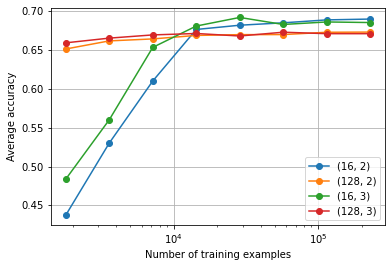

In [39]:
plt.semilogx(np.array(train_sizes)*2*7, np.array(all_all_accs[0]).mean(axis=1), '-o')
plt.semilogx(np.array(train_sizes)*2*7, np.array(all_all_accs[1]).mean(axis=1), '-o')
plt.semilogx(np.array(train_sizes)*2*7, np.array(all_all_accs[2]).mean(axis=1), '-o')
plt.semilogx(np.array(train_sizes)*2*7, np.array(all_all_accs[3]).mean(axis=1), '-o')
plt.grid()
plt.legend(model_configs)
plt.xlabel('Number of training examples'); plt.ylabel('Average accuracy')

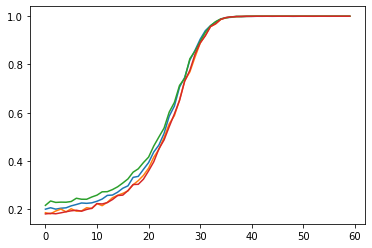

In [48]:
for accs in all_all_accs:
    plt.plot(np.array(accs)[4])

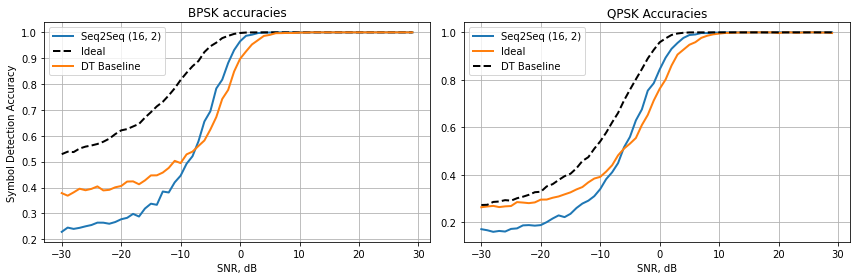

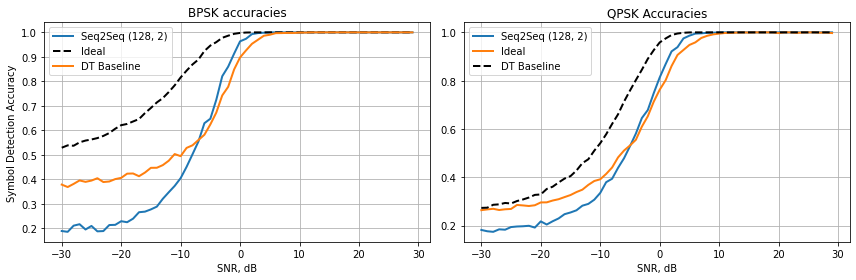

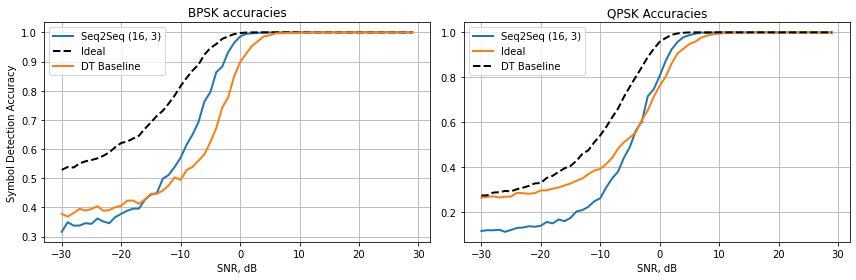

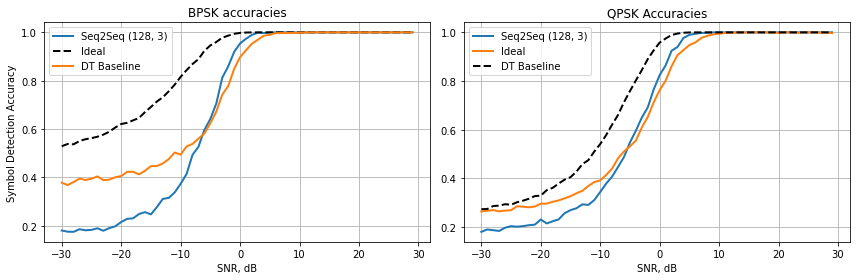

In [64]:
for model_config in model_configs:
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    result = torch.load(f"results/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{data_config['seq_length']}_trained_on_2048.pt")
    # plt.plot(np.array(result['bpsk_accs']))
    # plt.plot(np.array(result['qpsk_accs']))
    ax[0].plot(snr_range, np.array(result['bpsk_accs']), '-', linewidth=2)
    ax[0].plot(snr_range, np.array(bpsk_baseline), 'k--', linewidth=2)
    ax[0].plot(snr_range, saved['bpsk_baseline'], '-', linewidth=2)
    ax[0].grid()
    ax[0].legend((f'Seq2Seq {model_config}', 'Ideal', 'DT Baseline'))
    ax[0].set_xlabel('SNR, dB'); ax[0].set_ylabel('Symbol Detection Accuracy')
    ax[0].set_title('BPSK accuracies')


    ax[1].plot(snr_range, np.array(result['qpsk_accs']), '-', linewidth=2)
    ax[1].plot(snr_range, saved['qpsk_baseline'], '-', linewidth=2)
    ax[1].plot(snr_range, np.array(qpsk_baseline), 'k--', linewidth=2)
    ax[1].grid()
    ax[1].legend((f'Seq2Seq {model_config}', 'Ideal', 'DT Baseline'))
    ax[1].set_xlabel('SNR, dB'); ax[0].set_ylabel('Symbol Detection Accuracy')
    ax[1].set_title('QPSK Accuracies')

    plt.tight_layout()

In [71]:
from matplotlib.lines import Line2D

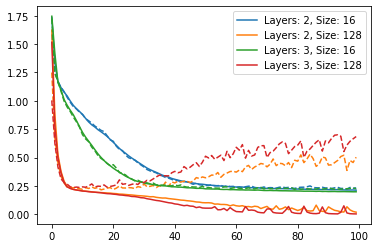

In [88]:
legend_elements = []
for idx, model_config in enumerate(model_configs):
    model = torch.load(f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{data_config['seq_length']}_trained_on_2048.pt")
    plt.plot(model['losses'], f'C{idx}')
    plt.plot(model['val_losses'], f'C{idx}--')

    legend_elements.append(Line2D([0], [0], color=f'C{idx}', label=f"Layers: {model_config[1]}, Size: {model_config[0]}"))

plt.legend(handles=legend_elements)

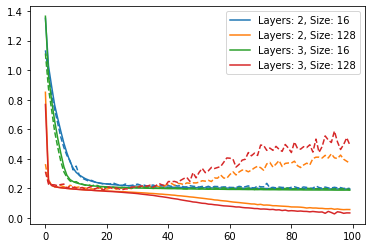

In [90]:
legend_elements = []
for idx, model_config in enumerate(model_configs):
    model = torch.load(f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{data_config['seq_length']}_trained_on_8192.pt")
    plt.plot(model['losses'], f'C{idx}')
    plt.plot(model['val_losses'], f'C{idx}--')

    legend_elements.append(Line2D([0], [0], color=f'C{idx}', label=f"Layers: {model_config[1]}, Size: {model_config[0]}"))

plt.legend(handles=legend_elements)